# Financial Fraud Detection

- The objective of this notebook is to showcase the usage of the [___financial-fraud-training___ container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/cugraph/containers/financial-fraud-training) and how to deploy the produced trained models on [NVIDIA Dynamo-Triton](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver).
- We use [IBM TabFormer](https://github.com/IBM/TabFormer) as an example dataset and the dataset is preprocess before model training

NOTE:
* The preprocessing code is written specifically for the TabFormer dataset and will not work with other datasets.
* Additionally, a familiarity with [Jupyter](https://docs.jupyter.org/en/latest/what_is_jupyter.html) is assumed.

# Environment Setup (Sagemaker studio)
This Notebook is designed to work in a Sagemaker studio jupyter lab notebook

Please create a Conda environment and add that to the notebook - See the [README - Setup Development Environment section](../README.md) file

In [37]:
!nvidia-smi --version

NVIDIA-SMI version  : 550.163.01
NVML version        : 550.163
DRIVER version      : 550.163.01
CUDA Version        : 12.6


### Activate the env in the kernel

Now choose the `fraud_blueprint_env` kernel from within jupyterlab for this notebook

-----
## Import libraries

In [38]:
import os
import sys
import json
import time
import boto3

## Prepare the AWS Environment variables from the infrastructure stack

In [39]:
def get_cfn_output(stack_name, output_key):
    try:
        response = cfn_client.describe_stacks(StackName=stack_name)
        outputs = response['Stacks'][0]['Outputs']
        for output in outputs:
            if output['OutputKey'] == output_key:
                return output['OutputValue']
        return None
    except Exception as e:
        if 'AccessDenied' in str(e) or 'UnauthorizedOperation' in str(e):
            print(f"Permission Error: You don't have permission to access CloudFormation stack '{stack_name}'.")
            print("   Please ensure the Sagemaker execution role has the 'cloudformation:DescribeStacks' permission.")
        else:
            print(f"Error accessing CloudFormation stack '{stack_name}': {str(e)}")
            print("   Please check that the stack exists and you have the permissions to read from it configured.")
        return None

def get_inference_host():
    try:
        response = elb_client.describe_load_balancers()["LoadBalancers"]
        
        for elb in response:
            if elb['LoadBalancerName'].startswith('k8s-triton'):
                return elb['DNSName']
        return None
    except Exception as e:
        if 'AccessDenied' in str(e) or 'UnauthorizedOperation' in str(e):
            print(f"Permission Error: You don't have permission to access Elastic Load Balancers.")
            print("   Please ensure the Sagemaker execution role has the 'elasticloadbalancing:DescribeLoadBalancers' permission.")
        else:
            print(f"Error accessing load balancers: {str(e)}")
            print("   Please check your AWS credentials and network connectivity.")
        return None

In [40]:
ssm_client = boto3.client('ssm')
cfn_client = boto3.client('cloudformation')
elb_client = boto3.client('elbv2', region_name="us-east-1")

bucket_name = get_cfn_output("NvidiaFraudDetectionBlueprintModelExtractor", "SourceBucketName")

sagemaker_training_role = get_cfn_output("NvidiaFraudDetectionTrainingRole", "SageMakerRoleArn")

training_repo = get_cfn_output("NvidiaFraudDetectionTrainingImageRepo", "TrainingImageRepoUri")

inference_host = get_inference_host()

print(f"Bucket Name: {bucket_name}")
print(f"Training Role: {sagemaker_training_role}")
print(f"Training Repo: {training_repo}")
print(f"Inference Host: {inference_host}")

Bucket Name: ml-on-containers-541765610078
Training Role: arn:aws:iam::541765610078:role/AmazonSageMaker-ExecutionRole-CDK
Training Repo: 541765610078.dkr.ecr.us-east-1.amazonaws.com/nvidia-training-repo
Inference Host: k8s-triton-tritonse-3c19d68b79-1976485266.us-east-1.elb.amazonaws.com


----
# Step 1: Get and Prepare the data

## For Local
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. untar and uncompreess the file: `tar -xvzf ./transactions.tgz`
3. Put card_transaction.v1.csv in in the `data/TabFormer/raw` folder


## For Brev 
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. In the Jupyter notebook window, use the "File Browser" section to the data/Tabformer/raw folder
3. Drag-and-drop the "transactions.tgz" file into the folder
    - There is also an "upload" option that displays a file selector
    - Please wait for the upload to finish, it could take a while, by lookign at the status indocator at the bottom of the window
4. Now uncompress and untar by running the following command
    - Note: if somethign goes wrong you will need to delete the file rather than trying to overwrite it.

In [41]:
# verify that the compressed file was uploaded successfully - the size should be 266M
!ls -lh ../data/TabFormer/raw

total 2.5G
-rw-r--r-- 1 sagemaker-user users 2.2G Oct 28  2020 card_transaction.v1.csv
-rw-r--r-- 1 sagemaker-user users  112 Nov 28 08:48 readme.md
-rw-r--r-- 1 sagemaker-user users 266M Nov 28 08:56 transactions.tgz


In [7]:
# Uncompress/untar the file
!tar xvzf ../data/TabFormer/raw/transactions.tgz -C ../data/TabFormer/raw/

tar (child): ../data/TabFormer/raw/transactions.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


__If__ drag-and-drop is not working, please run the [Download TabFormer](./extra/download-tabformer.ipynb) notebook is the "extra" folder 

## Check data folder structure
The goal is to produce the following structure

```
.
    data
    └── TabFormer
        └── raw
            └── card_transaction.v1.csv
```

In [42]:
# Once the raw data is placed as described above, set the path to the TabFormer directory

# Change this path to point to TabFormer data
data_root_dir = os.path.abspath('../data/TabFormer/') 
# Change this path to the directory where you want to save your model
model_output_dir = os.path.join(data_root_dir, 'trained_models')

# Path to save the trained model
os.makedirs(model_output_dir, exist_ok=True)

### Define python function to print directory tree

In [43]:
def print_tree(directory, prefix=""):
    """Recursively prints the directory tree starting at 'directory'."""
    # Retrieve a sorted list of entries in the directory
    entries = sorted(os.listdir(directory))
    entries_count = len(entries)
    
    for index, entry in enumerate(entries):
        path = os.path.join(directory, entry)
        # Determine the branch connector
        if index == entries_count - 1:
            connector = "└── "
            extension = "    "
        else:
            connector = "├── "
            extension = "│   "
        
        print(prefix + connector + entry)
        
        # If the entry is a directory, recursively print its contents
        if os.path.isdir(path):
            print_tree(path, prefix + extension)

In [10]:
# Check if the raw data has been placed properly
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   ├── node_to_node.csv
│   │   ├── user_to_merchant.csv
│   │   ├── user_to_merchant_attr.csv
│   │   └── user_to_merchant_label.csv
│   ├── nodes
│   │   ├── merchant.csv
│   │   ├── node.csv
│   │   ├── node_label.csv
│   │   ├── offset_range_of_training_node.json
│   │   └── user.csv
│   └── test_gnn
│       ├── edges
│       │   ├── node_to_node.csv
│       │   ├── user_to_merchant.csv
│       │   ├── user_to_merchant_attr.csv
│       │   ├── user_to_merchant_feature_mask.csv
│       │   └── user_to_merchant_label.csv
│       └── nodes
│           ├── merchant.csv
│           ├── merchant_feature_mask.csv
│           ├── node.csv
│           ├── node_label.csv
│           ├── user.csv
│           └── user_feature_mask.csv
├── raw
│   ├── card_transaction.v1.csv
│   └── readme.md
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


---
# Step 2: Preprocess the data 
- Import the Python function for preprocessing the TabFormer data
- Call `preprocess_TabFormer` function to prepare the data

NOTE: The preprocessing can takes a few minutes


In [11]:
# Add the "src" directory to the search path
src_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'src'))
sys.path.insert(0, src_dir)

# should be able to import from "src" folder now
from preprocess_TabFormer_lp import preprocess_data

In [12]:
# Preprocess the data
user_mask_map, mx_mask_map, tx_mask_map = preprocess_data(data_root_dir)

# this will output status as it correlates different attributes with target column

Correlation (Card, Fraud) =   6.59%
Correlation (Chip, Fraud) =   5.63%
Correlation (Errors, Fraud) =   1.81%
Correlation (State, Fraud) =  35.92%
Correlation (City, Fraud) =  32.47%
Correlation (Zip, Fraud) =  14.99%
Correlation (MCC, Fraud) =  12.70%
Correlation (Merchant, Fraud) =  34.88%
Correlation (User, Fraud) =   3.40%
Correlation (Day, Fraud) =   0.26%
Correlation (Month, Fraud) =   0.23%
Correlation (Year, Fraud) =   2.35%
r_pb (Time) = -0.00 with p_value 0.00
r_pb (Amount) = 0.03 with p_value 0.00
Transaction ID range (np.int64(0), np.int64(301523))
Merchant ID range (np.int64(0), np.int64(42941))
User ID range (np.int64(0), np.int64(4872))
Transaction ID range (np.int64(0), np.int64(25802))
Merchant ID range (np.int64(0), np.int64(6772))
User ID range (np.int64(0), np.int64(4794))


In [13]:
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   ├── node_to_node.csv
│   │   ├── user_to_merchant.csv
│   │   ├── user_to_merchant_attr.csv
│   │   └── user_to_merchant_label.csv
│   ├── nodes
│   │   ├── merchant.csv
│   │   ├── node.csv
│   │   ├── node_label.csv
│   │   ├── offset_range_of_training_node.json
│   │   └── user.csv
│   └── test_gnn
│       ├── edges
│       │   ├── node_to_node.csv
│       │   ├── user_to_merchant.csv
│       │   ├── user_to_merchant_attr.csv
│       │   ├── user_to_merchant_feature_mask.csv
│       │   └── user_to_merchant_label.csv
│       └── nodes
│           ├── merchant.csv
│           ├── merchant_feature_mask.csv
│           ├── node.csv
│           ├── node_label.csv
│           ├── user.csv
│           └── user_feature_mask.csv
├── raw
│   ├── card_transaction.v1.csv
│   └── readme.md
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


In [14]:
# copy data to S3 to get pulled during training
! aws s3 sync "../data/TabFormer/" s3://$bucket_name/data/ --exclude "*/test_gnn" --force --delete

upload: ../data/TabFormer/gnn/edges/user_to_merchant.csv to s3://ml-on-containers-771830474512/data/gnn/edges/user_to_merchant.csv
upload: ../data/TabFormer/gnn/nodes/user.csv to s3://ml-on-containers-771830474512/data/gnn/nodes/user.csv
upload: ../data/TabFormer/gnn/edges/user_to_merchant_label.csv to s3://ml-on-containers-771830474512/data/gnn/edges/user_to_merchant_label.csv
upload: ../data/TabFormer/gnn/nodes/merchant.csv to s3://ml-on-containers-771830474512/data/gnn/nodes/merchant.csv
upload: ../data/TabFormer/gnn/test_gnn/edges/user_to_merchant_feature_mask.csv to s3://ml-on-containers-771830474512/data/gnn/test_gnn/edges/user_to_merchant_feature_mask.csv
upload: ../data/TabFormer/gnn/test_gnn/edges/user_to_merchant_attr.csv to s3://ml-on-containers-771830474512/data/gnn/test_gnn/edges/user_to_merchant_attr.csv
upload: ../data/TabFormer/gnn/test_gnn/edges/user_to_merchant.csv to s3://ml-on-containers-771830474512/data/gnn/test_gnn/edges/user_to_merchant.csv
upload: ../data/TabFo

-----
# Step 3:  Now train the model using the financial-fraud-training container


## Create training configuration file
NOTE: Training configuration file must conform to schema defined in docs (to be updated.)

__Important: Models and configuration files needed for deployment using NVIDIA Dynamo-Triton will be saved in model-repository under the folder that is mounted in /trained_models inside the container__

In [44]:
training_config = {
  "paths": {
        "data_dir": "/opt/ml/input/data/data",
        "output_dir": "/opt/ml/model"
  },

  "models": [
    {
      "kind": "GNN_XGBoost",
      "gpu": "single",
      "hyperparameters": {
        "gnn":{
          "hidden_channels": 32,
          "n_hops": 2,
          "layer": "SAGEConv",
          "dropout_prob": 0.1,
          "batch_size": 4096,
          "fan_out": 10,
          "num_epochs": 1
        },
        "xgb": {
          "max_depth": 6,
          "learning_rate": 0.2,
          "num_parallel_tree": 3,
          "num_boost_round": 512,
          "gamma": 0.0
        }

      }
    }
  ]
}


#### Save the training configuration as a json file

In [45]:
training_config_file_name = 'training_config.json'

with open(os.path.join(training_config_file_name), 'w') as json_file:
    json.dump(training_config, json_file, indent=4)

# clone config to S3
! aws s3 cp ./training_config.json s3://$bucket_name/config/training_config.json

upload: ./training_config.json to s3://ml-on-containers-541765610078/config/training_config.json


## Train model using financial_fraud_training container

In [23]:
# run the training in Sagemaker
# define training job
training_job_name = "fraud-detection-gnn-" + str(int(time.time()))

# send training job to parameter store
ssm_client = boto3.client("ssm")

ssm_client.put_parameter(Name="/triton/model", Value=training_job_name, Overwrite=True)

sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.create_training_job(
    TrainingJobName=training_job_name,
    RoleArn=sagemaker_training_role,
    AlgorithmSpecification={
        'TrainingImage': f"{training_repo}:2.0.0",
        'TrainingInputMode': 'File',
        'ContainerEntrypoint': [
            'torchrun',
            '--standalone',
            '--nnodes=1',
            '--nproc_per_node=1',
            '/app/main.py',
            '--config',
            '/opt/ml/input/data/config/training_config.json'
        ]
    },
    InputDataConfig=[
        {
            'ChannelName': 'data',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': f's3://{bucket_name}/data/gnn/',
                    'S3DataDistributionType': 'FullyReplicated'
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        },
        {
            'ChannelName': 'config',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': f's3://{bucket_name}/config/',
                    'S3DataDistributionType': 'FullyReplicated',
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        }
    ],
    OutputDataConfig={
        'S3OutputPath': f's3://{bucket_name}/output/'
    },
    ResourceConfig={
        'InstanceType': 'ml.g5.xlarge',
        'InstanceCount': 1,
        'VolumeSizeInGB': 30
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 86400
    }
)

#### Make sure that the training job succeeds
According to the training configuration file defined earlier, if the training runs successfully

In [24]:
from IPython.display import clear_output
def poll_training_status(job_name):
    sagemaker_client = boto3.client('sagemaker')
    
    while True:
        response = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        status = response['TrainingJobStatus']
        
        # Clear previous output
        clear_output(wait=True)
        
        # Print current status with timestamp
        print(f"Job: {job_name}")
        print(f"Status: {status}")
        print(f"Last checked: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        
        if status in ['Completed', 'Failed', 'Stopped']:
            break
            
        # Wait before next check
        time.sleep(30)
    
    return status

In [25]:
final_status = poll_training_status(training_job_name)

Job: fraud-detection-gnn-1759164616
Status: Failed
Last checked: 2025-09-29 16:59:48


----
# Step 4:  Serve your python backend model using NVIDIA Dynamo-Triton
__!Important__: Change MODEL_REPO_PATH to point to `{model_output_dir}` / `python_backend_model_repository` if you used a different path in your training configuration file

#### Install NVIDIA Dynamo-Triton Client

In [46]:
!pip install 'tritonclient[all]'

In [47]:
import tritonclient.grpc as triton_grpc
import tritonclient.http as httpclient
from tritonclient import utils as triton_utils


##### Replace HOST with the actual URL where your NVIDIA Dynamo-Triton server is hosted.


In [48]:
HOST = inference_host
HTTP_PORT = 80
GRPC_PORT = 8006
METRICS_PORT = 8007

### Serve your models with NVIDIA Dynamo-Triton

With the infrastructure repo deployed, we have a Lambda function waiting for the training job to complete and for the models to be output to `s3://ml-on-containers-<accountnumber>/output` and then, they'll get extracted to a different bucket to be served by the inference host setup by our infrastructure.

### URLs for GRPC and HTTP request to the inference server

In [49]:
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
client_http = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

#### Here’s an example of how to prepare data for inference, using random data

In [51]:
import numpy as np

from tritonclient.http import InferenceServerClient, InferInput, InferRequestedOutput

def make_example_request():
    # -- example sizes --
    num_merchants = 5
    num_users   = 7
    num_edges   = 3
    merchant_feature_dim = 24
    user_feature_dim = 13
    user_to_merchant_feature_dim = 38

    # -- 1) features --
    x_merchant = np.random.randn(num_merchants, merchant_feature_dim).astype(np.float32)
    x_user   = np.random.randn(num_users, user_feature_dim).astype(np.float32)

    # -- 2) shap flag and masks --
    compute_shap          = np.array([True], dtype=np.bool_)
    feature_mask_merchant   = np.random.randint(0,2, size=(merchant_feature_dim,), dtype=np.int32)
    feature_mask_user     = np.random.randint(0,2, size=(user_feature_dim,), dtype=np.int32)

    # -- 3) edges: index [2, num_edges] and attributes [num_edges,user_to_merchant_feature_dim] --
    edge_index_user_to_merchant = np.vstack([
        np.random.randint(0, num_users,   size=(num_edges,)),
        np.random.randint(0, num_merchants, size=(num_edges,))
    ]).astype(np.int64)
    
    edge_attr_user_to_merchant = np.random.randn(num_edges, user_to_merchant_feature_dim).astype(np.float32)

    feature_mask_user_to_merchant =  np.random.randint(0,2, size=(user_to_merchant_feature_dim,), dtype=np.int32)

    return {
        "x_merchant": x_merchant,
        "x_user": x_user,
        "COMPUTE_SHAP": compute_shap,
        "feature_mask_merchant": feature_mask_merchant,
        "feature_mask_user": feature_mask_user,
        "edge_index_user_to_merchant": edge_index_user_to_merchant,
        "edge_attr_user_to_merchant": edge_attr_user_to_merchant,
        "edge_feature_mask_user_to_merchant": feature_mask_user_to_merchant
    }



In [52]:
def prepare_and_send_inference_request(data):

    # Connect to Triton
    client = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

    # Prepare Inputs

    inputs = []
    def _add_input(name, arr, dtype):
        inp = InferInput(name, arr.shape, datatype=dtype)
        inp.set_data_from_numpy(arr)
        inputs.append(inp)

    for key, value in data.items():
        if key.startswith("x_"):
            dtype = "FP32"
        elif key.startswith("feature_mask_"):
            dtype = "INT32"
        elif key.startswith("edge_feature_mask_"):
            dtype = "INT32"            
        elif key.startswith("edge_index_"):
            dtype = "INT64"
        elif key.startswith("edge_attr_"):
            dtype = "FP32"
        elif key == "COMPUTE_SHAP":
            dtype = "BOOL"
        else:
            continue  # skip things we don't care about

        _add_input(key, value, dtype)


    # Outputs

    outputs = [InferRequestedOutput("PREDICTION")]

    for key in data:
        if key.startswith("x_"):
            node = key[len("x_"):]  # extract node name
            outputs.append(InferRequestedOutput(f"shap_values_{node}"))
        elif key.startswith("edge_attr_"):
            edge_name = key[len("edge_attr_"):]  # extract edge name
            outputs.append(InferRequestedOutput(f"shap_values_{edge_name}"))
    
    # Send request

    model_name="prediction_and_shapley"
    response = client.infer(
        model_name,
        inputs=inputs,
        request_id=str(1),
        outputs=outputs,
        timeout= 3000
    )

    result = {}

    # always include prediction
    result["PREDICTION"] = response.as_numpy("PREDICTION")

    # add shap values
    for key in data:
        if key.startswith("x_"):
            node = key[len("x_"):]  # e.g. "merchant", "user"
            result[f"shap_values_{node}"] = response.as_numpy(f"shap_values_{node}")
        if key.startswith("edge_attr_"):
            edge_name = key[len("edge_attr_"):]  # e.g. ("user" "to"  "merchant")
            result[f"shap_values_{edge_name}"] = response.as_numpy(f"shap_values_{edge_name}")
    
    return result


## Prediction without computing Shapley values

### Read preprocessed input transactions to send query to NVIDIA Dynamo-Triton

In [53]:
import os
import pandas as pd
import numpy as np

def load_hetero_graph(gnn_data_dir):
    """
    Reads:
      - All node CSVs from nodes/, plus their matching feature masks (<node>_feature_mask.csv)
        If missing, a mask of all ones is created (np.int32).
      - All edge CSVs from edges/:
          base        -> edge_index_<edge> (np.int64)
          *_attr.csv  -> edge_attr_<edge>  (np.float32)
          *_label.csv -> exactly one -> edge_label_<edge> (DataFrame)
    """
    base = os.path.join(gnn_data_dir, "test_gnn")
    nodes_dir = os.path.join(base, "nodes")
    edges_dir = os.path.join(base, "edges")

    out = {}
    node_feature_mask = {}

    # --- Nodes: every CSV becomes x_<node>; also read/create feature_mask_<node> ---
    if os.path.isdir(nodes_dir):
        for fname in os.listdir(nodes_dir):
            if fname.lower().endswith(".csv") and not fname.lower().endswith("_feature_mask.csv"):
                node_name = fname[:-len(".csv")]
                node_path = os.path.join(nodes_dir, fname)
                node_df = pd.read_csv(node_path)
                out[f"x_{node_name}"] = node_df.to_numpy(dtype=np.float32)

                # feature mask file (optional)
                mask_fname = f"{node_name}_feature_mask.csv"
                mask_path = os.path.join(nodes_dir, mask_fname)
                if os.path.exists(mask_path):
                    mask_df = pd.read_csv(mask_path, header=None)
                    node_feature_mask[node_name] = mask_df
                    feature_mask = mask_df.to_numpy(dtype=np.int32).ravel()
                else:
                    # create a must with all zeros
                    feature_mask = np.zeros(node_df.shape[1], dtype=np.int32)
                out[f"feature_mask_{node_name}"] = feature_mask

    # --- Edges: group into base, attr, label by filename suffix ---
    base_edges = {}
    edge_attrs = {}
    edge_labels = {}
    edge_feature_mask = {}

    if os.path.isdir(edges_dir):
        for fname in os.listdir(edges_dir):
            if not fname.lower().endswith(".csv"):
                continue
            path = os.path.join(edges_dir, fname)
            lower = fname.lower()
            if lower.endswith("_attr.csv"):
                edge_name = fname[:-len("_attr.csv")]
                edge_attrs[edge_name] = pd.read_csv(path) #, header=None)
            elif lower.endswith("_label.csv"):
                edge_name = fname[:-len("_label.csv")]
                edge_labels[edge_name] = pd.read_csv(path)
            elif lower.endswith("_feature_mask.csv"):
                edge_name = fname[:-len("_feature_mask.csv")]
                edge_feature_mask[edge_name] = pd.read_csv(path, header=None)
            else:
                edge_name = fname[:-len(".csv")]
                base_edges[edge_name] = pd.read_csv(path) #, header=None)



    # Enforce: only one label file total
    if len(edge_labels) == 0:
        raise FileNotFoundError("No '*_label.csv' found in edges/. Exactly one label file is required.")
    if len(edge_labels) > 1:
        raise ValueError(f"Found multiple label files: {list(edge_labels.keys())}. Exactly one is allowed.")

    # Build output keys for edges
    for edge_name, df in base_edges.items():
        out[f"edge_index_{edge_name}"] = df.to_numpy(dtype=np.int64).T
        if edge_name in edge_attrs:
            out[f"edge_attr_{edge_name}"] = edge_attrs[edge_name].to_numpy(dtype=np.float32)
        if edge_name in edge_feature_mask:
            out[f"edge_feature_mask_{edge_name}"] = edge_feature_mask[edge_name].to_numpy(dtype=np.int32).ravel()
        else:
            # create a must with all zeros
            out[f"edge_feature_mask_{edge_name}"] = np.zeros(edge_attrs[edge_name].shape[1], dtype=np.int32)

        

    # Add the single label file (kept as DataFrame)
    (label_edge_name, label_df), = edge_labels.items()
    out[f"edge_label_{label_edge_name}"] = label_df

    return out

In [54]:

gnn_data_dir = os.path.join(data_root_dir, "gnn")
test_data = load_hetero_graph(gnn_data_dir)
compute_shap = False
result =  prepare_and_send_inference_request(test_data | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)})

In [55]:
result['PREDICTION']

array([[1.1586075e-02],
       [9.0501761e-01],
       [3.9595976e-02],
       ...,
       [4.5441482e-03],
       [2.1851293e-04],
       [6.4205920e-04]], dtype=float32)

### Evaluate performance on test data

In [56]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [57]:

def compute_score_for_batch(y, predictions, decision_threshold = 0.5):
    # Apply threshold
    y_pred = (predictions > decision_threshold).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)

    # Confusion matrix
    classes = ['Non-Fraud', 'Fraud']
    columns = pd.MultiIndex.from_product([["Predicted"], classes])
    index = pd.MultiIndex.from_product([["Actual"], classes])

    conf_mat = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(conf_mat, index=index, columns=columns)
    print(cm_df)

    # Plot the confusion matrix directly
    disp = ConfusionMatrixDisplay.from_predictions(
        y, y_pred, display_labels=classes
    )
    disp.ax_.set_title('Confusion Matrix')
    plt.show()

    # Print summary
    print("----Summary---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


#### Scores on test data

                 Predicted      
                 Non-Fraud Fraud
Actual Non-Fraud     23619    97
       Fraud            93  1994


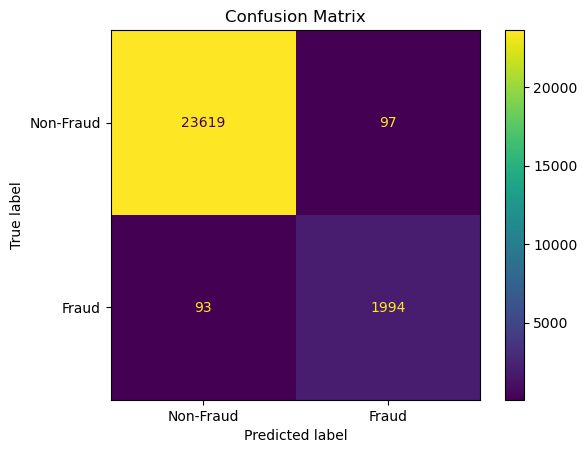

----Summary---
Accuracy:  0.9926
Precision: 0.9536
Recall:    0.9554
F1 Score:  0.9545


In [58]:
# Decision threshold to flag a transaction as fraud
#Change to trade-off precision and recall
decision_threshold = 0.5
y = test_data['edge_label_user_to_merchant'].to_numpy(dtype=np.int32)
compute_score_for_batch(y, result['PREDICTION'], decision_threshold)

---
# Step 5: Latency and Throughput Tests

Measure inference performance with **realistic request sizes**:
- **Single transaction**: 1 edge + connected user/merchant (real-time fraud scoring)
- **Small batch**: 10-100 transactions (micro-batch processing)
- **Varying batch sizes**: Latency scaling analysis

In [59]:
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import statistics

def extract_subgraph(full_data, edge_indices, gnn_data_dir):
    """
    Extract a subgraph containing only the specified edges and their connected nodes.
    
    Args:
        full_data: Full test graph data from load_hetero_graph()
        edge_indices: List of edge indices to include
        gnn_data_dir: Path to GNN data directory
    
    Returns:
        Subgraph data dict ready for inference
    """
    # Get edge data
    edge_index = full_data['edge_index_user_to_merchant']  # shape (2, num_edges)
    edge_attr = full_data['edge_attr_user_to_merchant']    # shape (num_edges, 38)
    
    # Extract selected edges
    selected_edge_index = edge_index[:, edge_indices]
    selected_edge_attr = edge_attr[edge_indices, :]
    
    # Find unique users and merchants in selected edges
    selected_users = np.unique(selected_edge_index[0, :])
    selected_merchants = np.unique(selected_edge_index[1, :])
    
    # Create mapping from old IDs to new contiguous IDs
    user_id_map = {old_id: new_id for new_id, old_id in enumerate(selected_users)}
    merchant_id_map = {old_id: new_id for new_id, old_id in enumerate(selected_merchants)}
    
    # Remap edge indices to new contiguous IDs
    remapped_edge_index = np.zeros_like(selected_edge_index)
    for i in range(selected_edge_index.shape[1]):
        remapped_edge_index[0, i] = user_id_map[selected_edge_index[0, i]]
        remapped_edge_index[1, i] = merchant_id_map[selected_edge_index[1, i]]
    
    # Extract node features for selected nodes
    x_user = full_data['x_user'][selected_users, :]
    x_merchant = full_data['x_merchant'][selected_merchants, :]
    
    # Build subgraph data
    subgraph = {
        'x_user': x_user,
        'x_merchant': x_merchant,
        'feature_mask_user': full_data['feature_mask_user'],
        'feature_mask_merchant': full_data['feature_mask_merchant'],
        'edge_index_user_to_merchant': remapped_edge_index,
        'edge_attr_user_to_merchant': selected_edge_attr,
        'edge_feature_mask_user_to_merchant': full_data['edge_feature_mask_user_to_merchant'],
    }
    
    return subgraph

def create_batch_samples(full_data, batch_size, num_samples, gnn_data_dir):
    """Create multiple subgraph samples of a given batch size."""
    num_edges = full_data['edge_index_user_to_merchant'].shape[1]
    samples = []
    
    for _ in range(num_samples):
        # Randomly select batch_size edges
        edge_indices = np.random.choice(num_edges, size=min(batch_size, num_edges), replace=False)
        subgraph = extract_subgraph(full_data, edge_indices, gnn_data_dir)
        samples.append(subgraph)
    
    return samples

def print_subgraph_stats(subgraph, label=""):
    """Print statistics about a subgraph."""
    num_users = subgraph['x_user'].shape[0]
    num_merchants = subgraph['x_merchant'].shape[0]
    num_edges = subgraph['edge_index_user_to_merchant'].shape[1]
    print(f"{label}: {num_edges} transactions, {num_users} users, {num_merchants} merchants")

### Create Realistic Test Samples
Generate subgraphs of varying sizes to simulate real-world request patterns.

In [61]:
# Load full test data
full_test_data = load_hetero_graph(gnn_data_dir)

# Create samples for different batch sizes
batch_sizes = [1, 10, 50, 100]
num_samples_per_size = 100  # Number of samples to create for each batch size

test_samples = {}
for batch_size in batch_sizes:
    samples = create_batch_samples(full_test_data, batch_size, num_samples_per_size, gnn_data_dir)
    test_samples[batch_size] = samples
    print_subgraph_stats(samples[0], f"Batch size {batch_size} (example)")

print(f"\nCreated {num_samples_per_size} samples for each batch size: {batch_sizes}")

Batch size 1 (example): 1 transactions, 1 users, 1 merchants
Batch size 10 (example): 10 transactions, 10 users, 10 merchants
Batch size 50 (example): 50 transactions, 50 users, 44 merchants
Batch size 100 (example): 100 transactions, 100 users, 87 merchants

Created 100 samples for each batch size: [1, 10, 50, 100]


### Single Transaction Latency (Real-time Fraud Scoring)
This is the most critical metric: how fast can we score a single incoming transaction?

In [62]:
def measure_latency_for_samples(samples, compute_shap=False, warmup=5):
    """Measure latency for a list of subgraph samples."""
    latencies = []
    
    # Warmup with first sample
    warmup_data = samples[0] | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
    for _ in range(warmup):
        prepare_and_send_inference_request(warmup_data)
    
    # Measure each sample
    for i, sample in enumerate(samples):
        request_data = sample | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
        
        start = time.perf_counter()
        prepare_and_send_inference_request(request_data)
        end = time.perf_counter()
        
        latencies.append((end - start) * 1000)  # Convert to ms
        
        if (i + 1) % 20 == 0:
            print(f"  Completed {i + 1}/{len(samples)} requests...")
    
    return latencies

def print_latency_stats(latencies, label=""):
    """Print latency statistics."""
    if len(latencies) < 2:
        print(f"Not enough samples for statistics (got {len(latencies)})")
        return
        
    latencies_sorted = sorted(latencies)
    n = len(latencies)
    
    print(f"\n{'='*55}")
    print(f"  {label}")
    print(f"{'='*55}")
    print(f"  Requests:    {n}")
    print(f"  Mean:        {statistics.mean(latencies):>8.2f} ms")
    print(f"  Std Dev:     {statistics.stdev(latencies):>8.2f} ms")
    print(f"  Min:         {min(latencies):>8.2f} ms")
    print(f"  Max:         {max(latencies):>8.2f} ms")
    print(f"  P50:         {latencies_sorted[int(n * 0.50)]:>8.2f} ms")
    print(f"  P90:         {latencies_sorted[int(n * 0.90)]:>8.2f} ms")
    print(f"  P95:         {latencies_sorted[int(n * 0.95)]:>8.2f} ms")
    print(f"  P99:         {latencies_sorted[min(int(n * 0.99), n-1)]:>8.2f} ms")
    print(f"{'='*55}")

In [63]:
# Measure single transaction latency (batch_size=1)
print("Measuring SINGLE TRANSACTION latency (batch_size=1)...")
single_tx_latencies = measure_latency_for_samples(test_samples[1], compute_shap=False)
print_latency_stats(single_tx_latencies, "Single Transaction Latency (without SHAP)")

Measuring SINGLE TRANSACTION latency (batch_size=1)...
  Completed 20/100 requests...
  Completed 40/100 requests...
  Completed 60/100 requests...
  Completed 80/100 requests...
  Completed 100/100 requests...

  Single Transaction Latency (without SHAP)
  Requests:    100
  Mean:           25.49 ms
  Std Dev:         0.77 ms
  Min:            24.37 ms
  Max:            28.12 ms
  P50:            25.36 ms
  P90:            26.52 ms
  P95:            27.34 ms
  P99:            28.12 ms


### Latency vs Batch Size
How does latency scale as we increase the number of transactions per request?

In [64]:
# Measure latency for different batch sizes
latency_by_batch_size = {}

for batch_size in batch_sizes:
    print(f"\nMeasuring latency for batch_size={batch_size}...")
    latencies = measure_latency_for_samples(test_samples[batch_size], compute_shap=False)
    latency_by_batch_size[batch_size] = latencies
    print_latency_stats(latencies, f"Batch Size = {batch_size} transactions")


Measuring latency for batch_size=1...
  Completed 20/100 requests...
  Completed 40/100 requests...
  Completed 60/100 requests...
  Completed 80/100 requests...
  Completed 100/100 requests...

  Batch Size = 1 transactions
  Requests:    100
  Mean:           25.43 ms
  Std Dev:         0.79 ms
  Min:            23.93 ms
  Max:            28.52 ms
  P50:            25.34 ms
  P90:            26.32 ms
  P95:            26.89 ms
  P99:            28.52 ms

Measuring latency for batch_size=10...
  Completed 20/100 requests...
  Completed 40/100 requests...
  Completed 60/100 requests...
  Completed 80/100 requests...
  Completed 100/100 requests...

  Batch Size = 10 transactions
  Requests:    100
  Mean:           26.32 ms
  Std Dev:         0.77 ms
  Min:            25.03 ms
  Max:            29.78 ms
  P50:            26.19 ms
  P90:            27.20 ms
  P95:            27.85 ms
  P99:            29.78 ms

Measuring latency for batch_size=50...
  Completed 20/100 requests...
  Com

### Throughput Test (Concurrent Single-Transaction Requests)
Simulate multiple users submitting transactions simultaneously.

In [65]:
def measure_throughput(samples, num_workers=10, compute_shap=False):
    """Measure throughput with concurrent requests using realistic single-tx samples."""
    latencies = []
    errors = 0
    
    # Cycle through samples for each request
    sample_cycle = samples * (len(samples) // num_workers + 1)  # Ensure enough samples
    
    def send_request(sample):
        try:
            request_data = sample | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
            start = time.perf_counter()
            prepare_and_send_inference_request(request_data)
            end = time.perf_counter()
            return (end - start) * 1000, None
        except Exception as e:
            return None, str(e)
    
    num_requests = len(samples)
    print(f"Running throughput test: {num_requests} requests, {num_workers} concurrent workers...")
    
    overall_start = time.perf_counter()
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(send_request, sample_cycle[i]) for i in range(num_requests)]
        
        for future in as_completed(futures):
            latency, error = future.result()
            if error:
                errors += 1
            else:
                latencies.append(latency)
    
    overall_end = time.perf_counter()
    total_time = overall_end - overall_start
    
    successful = len(latencies)
    throughput = successful / total_time
    
    print(f"\n{'='*55}")
    print(f"  Throughput Test Results ({num_workers} workers)")
    print(f"{'='*55}")
    print(f"  Total requests:     {num_requests}")
    print(f"  Successful:         {successful}")
    print(f"  Errors:             {errors}")
    print(f"  Total time:         {total_time:.2f} s")
    print(f"  Throughput:         {throughput:.2f} tx/s")
    if latencies:
        print(f"  Avg latency:        {statistics.mean(latencies):.2f} ms")
        print(f"  P95 latency:        {sorted(latencies)[int(len(latencies) * 0.95)]:.2f} ms")
    print(f"{'='*55}")
    
    return throughput, latencies

In [66]:
# Test throughput with different concurrency levels using single-transaction requests
concurrency_levels = [1, 5, 10, 20]
throughput_results = {}

for num_workers in concurrency_levels:
    throughput, _ = measure_throughput(test_samples[1], num_workers=num_workers, compute_shap=False)
    throughput_results[num_workers] = throughput
    print()

Running throughput test: 100 requests, 1 concurrent workers...

  Throughput Test Results (1 workers)
  Total requests:     100
  Successful:         100
  Errors:             0
  Total time:         2.53 s
  Throughput:         39.54 tx/s
  Avg latency:        25.24 ms
  P95 latency:        26.10 ms

Running throughput test: 100 requests, 5 concurrent workers...

  Throughput Test Results (5 workers)
  Total requests:     100
  Successful:         100
  Errors:             0
  Total time:         2.16 s
  Throughput:         46.37 tx/s
  Avg latency:        105.56 ms
  P95 latency:        110.17 ms

Running throughput test: 100 requests, 10 concurrent workers...

  Throughput Test Results (10 workers)
  Total requests:     100
  Successful:         100
  Errors:             0
  Total time:         2.16 s
  Throughput:         46.39 tx/s
  Avg latency:        205.48 ms
  P95 latency:        217.18 ms

Running throughput test: 100 requests, 20 concurrent workers...

  Throughput Test Re

### Visualizations

/tmp/ipykernel_13570/463328607.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes], patch_artist=True)


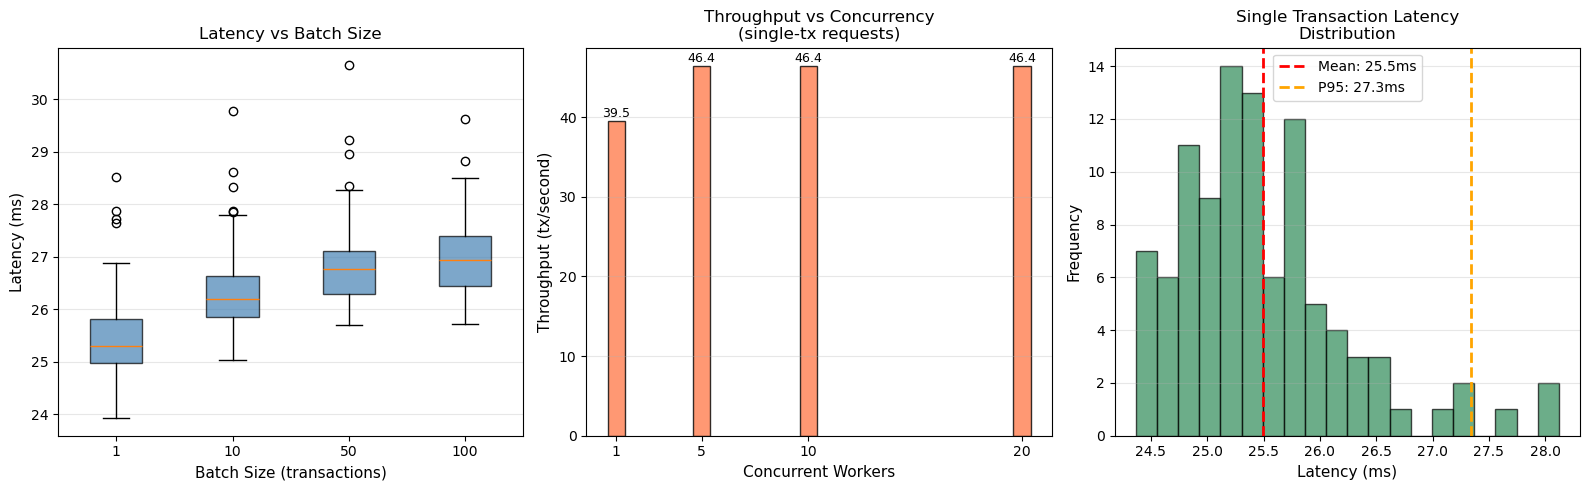

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Latency vs Batch Size (box plot)
ax1 = axes[0]
batch_data = [latency_by_batch_size[bs] for bs in batch_sizes]
bp = ax1.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
ax1.set_xlabel('Batch Size (transactions)', fontsize=11)
ax1.set_ylabel('Latency (ms)', fontsize=11)
ax1.set_title('Latency vs Batch Size', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Throughput vs Concurrency
ax2 = axes[1]
workers = list(throughput_results.keys())
throughputs = list(throughput_results.values())
bars = ax2.bar(workers, throughputs, color='coral', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Concurrent Workers', fontsize=11)
ax2.set_ylabel('Throughput (tx/second)', fontsize=11)
ax2.set_title('Throughput vs Concurrency\n(single-tx requests)', fontsize=12)
ax2.set_xticks(workers)
for bar, t in zip(bars, throughputs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{t:.1f}', ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Single Transaction Latency Distribution
ax3 = axes[2]
ax3.hist(single_tx_latencies, bins=20, color='seagreen', edgecolor='black', alpha=0.7)
mean_lat = statistics.mean(single_tx_latencies)
p95_lat = sorted(single_tx_latencies)[int(len(single_tx_latencies) * 0.95)]
ax3.axvline(mean_lat, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_lat:.1f}ms')
ax3.axvline(p95_lat, color='orange', linestyle='--', linewidth=2, label=f'P95: {p95_lat:.1f}ms')
ax3.set_xlabel('Latency (ms)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Single Transaction Latency\nDistribution', fontsize=12)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Summary Table

In [68]:
# Build summary table comparing latency across batch sizes
summary_rows = []
for batch_size in batch_sizes:
    lats = latency_by_batch_size[batch_size]
    lats_sorted = sorted(lats)
    n = len(lats)
    summary_rows.append({
        'Batch Size': batch_size,
        'Mean (ms)': f"{statistics.mean(lats):.2f}",
        'P50 (ms)': f"{lats_sorted[int(n * 0.50)]:.2f}",
        'P95 (ms)': f"{lats_sorted[int(n * 0.95)]:.2f}",
        'P99 (ms)': f"{lats_sorted[min(int(n * 0.99), n-1)]:.2f}",
        'Min (ms)': f"{min(lats):.2f}",
        'Max (ms)': f"{max(lats):.2f}",
        'Latency/Tx (ms)': f"{statistics.mean(lats) / batch_size:.2f}"
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.set_index('Batch Size', inplace=True)

print("\n" + "="*70)
print("  LATENCY SUMMARY BY BATCH SIZE")
print("="*70)
display(summary_df)

# Key insights
single_tx_mean = statistics.mean(latency_by_batch_size[1])
batch_100_mean = statistics.mean(latency_by_batch_size[100])
print(f"\nKey Insights:")
print(f"  - Single transaction P95 latency: {sorted(latency_by_batch_size[1])[int(len(latency_by_batch_size[1]) * 0.95)]:.2f} ms")
print(f"  - Batching 100 tx reduces per-tx latency by {(1 - (batch_100_mean/100) / single_tx_mean) * 100:.1f}%")
print(f"  - Max throughput (20 workers): {throughput_results.get(20, 'N/A'):.1f} tx/s" if 20 in throughput_results else "")


  LATENCY SUMMARY BY BATCH SIZE


,Mean (ms),P50 (ms),P95 (ms),P99 (ms),Min (ms),Max (ms),Latency/Tx (ms)
Batch Size,,,,,,,
1,25.43,25.34,26.89,28.52,23.93,28.52,25.43
10,26.32,26.19,27.85,29.78,25.03,29.78,2.63
50,26.83,26.76,28.27,30.65,25.71,30.65,0.54
100,26.96,26.93,28.02,29.63,25.71,29.63,0.27



Key Insights:
  - Single transaction P95 latency: 26.89 ms
  - Batching 100 tx reduces per-tx latency by 98.9%
  - Max throughput (20 workers): 46.4 tx/s
